# Writing CUDA kernels in Python

In this session we learn about how we can write simple kernels in python, translate them into C++ code using an LLM and leverage pytorch's tool to compile the kernel into a module we can load and execute from python.

Video link: https://www.youtube.com/watch?v=4sgKnKbR-WE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b4rdos/gpu-mode-notes/blob/master/notebooks/03-kernels-in-python/03-kernels-in-python.ipynb)

In [1]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.8 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Tue Jul 22 09:10:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except ImportError:
        return False


IN_COLAB = in_colab()
image_path = "./data/cats-window.jpg"
if IN_COLAB:
    image_path = "https://raw.githubusercontent.com/b4rdos/gpu-mode-notes/refs/heads/main/notebooks/03-kernels-in-python/data/cats-window.jpg"

In [1]:
import os
import math
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf

from torchvision import io
from torch.utils.cpp_extension import load_inline

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Let's load the image as a tensor

In [5]:
def load_image():
    if IN_COLAB:
        import requests
        return requests.get(image_path, stream=True).raw
    else:
        return open(image_path, "rb")

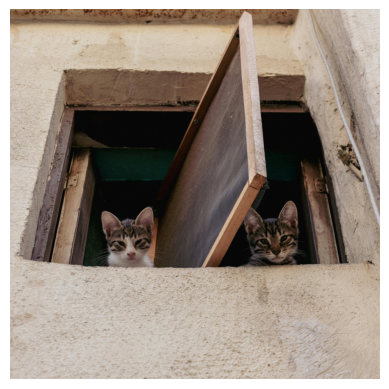

In [6]:
# prompt: Use PIL.Image with image loaded in bytes.
bytes_data = load_image()
img_pil = Image.open(bytes_data)
plt.imshow(img_pil)
plt.axis('off')
plt.show()

In [7]:
# prompt: Convert pil image to torch tensor


img_tensor = tvf.to_tensor(img_pil)
print(f"Shape of torch tensor: {img_tensor.shape}")

Shape of torch tensor: torch.Size([3, 3794, 3794])


In [8]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape)==3: x = x.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [9]:
img2 = tvf.resize(img_tensor, 150, antialias=True)
ch, h, w = img2.shape
print(ch, h, w)

3 150 150


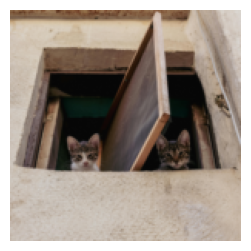

In [10]:
show_img(img2)

In [11]:
def rgb2grey_py(x: torch.Tensor) -> torch.Tensor:
    assert len(x.shape) == 3
    c,h,w = x.shape
    n = h * w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n):
        res[i] = 0.299 * x[i] + 0.587 * x[i + n] + 0.114 * x[i + 2 * n]
    return res.view(h, w)


In [12]:
img2[:, :3, :3]

tensor([[[0.5476, 0.5351, 0.5061],
         [0.5001, 0.4746, 0.4396],
         [0.5146, 0.5129, 0.4851]],

        [[0.4161, 0.3957, 0.3562],
         [0.3560, 0.3258, 0.2791],
         [0.3811, 0.3784, 0.3415]],

        [[0.2913, 0.2752, 0.2405],
         [0.2391, 0.2142, 0.1764],
         [0.2668, 0.2648, 0.2314]]])

In [13]:
img2[:, :3, :3].flatten()

tensor([0.5476, 0.5351, 0.5061, 0.5001, 0.4746, 0.4396, 0.5146, 0.5129, 0.4851,
        0.4161, 0.3957, 0.3562, 0.3560, 0.3258, 0.2791, 0.3811, 0.3784, 0.3415,
        0.2913, 0.2752, 0.2405, 0.2391, 0.2142, 0.1764, 0.2668, 0.2648, 0.2314])

In [14]:
%time img2_grey = rgb2grey_py(img2)

CPU times: user 763 ms, sys: 1.13 ms, total: 764 ms
Wall time: 765 ms


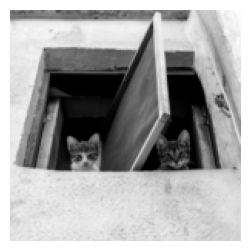

In [15]:
show_img(img2_grey, cmap="grey")

## Block Kernel

GPUs have what is called Streaming Multiprocessors (SMs) that are able to execute multiple threads concurrently.

In [16]:

def blk_1D_kernel(f, blocks, threads, *args):
    for b in range(blocks):
        for t in range(threads):
            f(b, t, threads, *args)

In [17]:
def rgb2grey_bl(blockidx, threadidx, blockdim, x, out, n) -> None:
    i = blockidx * blockdim + threadidx
    if i >= n:
        return
    out[i] = 0.299 * x[i] + 0.587 * x[i + n] + 0.114 * x[i + 2 * n]

In [18]:
THREADS_1D = 256
def rgb2grey_gpu(x):
    assert len(x.shape) == 3
    c,h,w = x.shape
    n = h * w
    x = x.flatten()
    out = torch.empty(n, dtype=x.dtype, device=x.device)
    blk_1D_kernel(rgb2grey_bl, math.ceil(n / THREADS_1D), THREADS_1D, x, out, n)
    return out.view(h, w)

In [19]:
%time img2_grey_gpu = rgb2grey_gpu(img2)

CPU times: user 764 ms, sys: 1.19 ms, total: 765 ms
Wall time: 766 ms


In [20]:
torch.testing.assert_close(img2_grey, img2_grey_gpu)

## CUDA Setup

We will define some default items for using CUDA

In [3]:
# If an error happens stop right away
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

In [4]:
%load_ext wurlitzer

In [5]:
# Utility function to compile our cuda kernel and return the module
def load_cuda(
        cuda_src,
        cpp_src,
        funcs,
        name="inline_ext",
        opt=False,
        verbose=False
    ):
    return load_inline(
        name="inline_ext",
        cpp_sources=[cpp_src],
        cuda_sources=[cuda_src],
        functions=funcs,
        extra_cuda_cflags=["-O2"] if opt else [],
        verbose=verbose
    )

In [6]:
cuda_begin = r"""
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) {
    return (a + b - 1) / b;
}
"""

### Cuda Kernel

Blocks sizes
* max $2^{32}$ if 1D
* max $2^{16}$ if 2D
* max $2^{8}$ if 3D

Threads sizes
* Max 1024
* Preferred multiple of 32
* Safe ~256 or 32 for 2D

#### Python Kernel to Cuda

We can leverage GPT or other LLM models to help us with the translation. Example prompt:

>Convert the following python code to equivalent C code using the same names, formatting etc where possible
>```python
def rgb2grey_bl(blockidx, threadidx, blockdim, x, out, n) -> None:
    i = blockidx * blockdim + threadidx
    if i >= n:
        return
    out[i] = 0.299 * x[i] + 0.587 * x[i + n] + 0.114 * x[i + 2 * n]
```

We got

```c

void rgb2grey_bl(int blockidx, int threadidx, int blockdim, const float* x, float* out, int n) {
    int i = blockidx * blockdim + threadidx;
    if (i >= n) {
        return;
    }
    out[i] = 0.299f * x[i] + 0.587f * x[i + n] + 0.114f * x[i + 2 * n];
}
```

Which is pretty good. We will need to make some changes but it's 80% there.


In [25]:
cuda_src = cuda_begin + r"""
__global__ void rgb_to_greyscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= n) {
        return;
    }
    out[i] = 0.299 * x[i] + 0.587 * x[i + n] + 0.114 * x[i + 2 * n];
}

torch::Tensor rgb_to_greyscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    // Initialise output
    auto output = torch::empty({h, w}, input.options());
    int threads = 256;
    int blocks = cdiv(h * w, threads);
    rgb_to_greyscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), h * w
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""


In [26]:
cpp_src = "torch::Tensor rgb_to_greyscale(torch::Tensor input);"

In [27]:
module = load_cuda(cuda_src, cpp_src, ["rgb_to_greyscale"], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include

Loading extension module inline_ext...


In [28]:
module.rgb_to_greyscale((img2 * 256).to(torch.uint8).to("cuda"))

tensor([[112, 107,  98,  ..., 214, 212, 213],
        [ 98,  91,  80,  ..., 216, 213, 214],
        [103, 103,  94,  ..., 211, 211, 212],
        ...,
        [189, 196, 197,  ..., 178, 175, 181],
        [184, 192, 192,  ..., 178, 180, 182],
        [189, 191, 192,  ..., 180, 178, 179]], device='cuda:0',
       dtype=torch.uint8)

In [30]:
img_tensor_cuda = (img_tensor * 255).contiguous().to(torch.uint8).to("cuda")
%time img_grey = module.rgb_to_greyscale(img_tensor_cuda).to("cpu") / 255

CPU times: user 17.4 ms, sys: 53 ms, total: 70.4 ms
Wall time: 69.8 ms


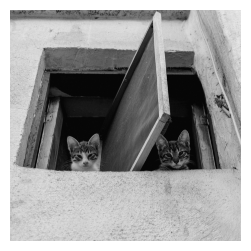

In [31]:
show_img(img_grey, cmap="grey")

We were able to shave off some time and have a result from the full image. Let's compare to a vectorised version.

In [ ]:
def rgb2grey_vectorised(x):
    return 0.299 * x[0] + 0.587 * x[1] + 0.114 * x[2]

In [ ]:
rgb2grey_vectorised(img2).shape

In [ ]:
torch.testing.assert_close(img2_grey, rgb2grey_vectorised(img2))

In [ ]:
%time img_grey_vectorised = rgb2grey_vectorised(img_tensor)

In [ ]:
%time img_grey_vectorised = rgb2grey_vectorised(img_tensor.to("cuda")).to("cpu")

Not as impressive, in fact it's slightly slower. But the point is to learn about kernel programming with python. In the next section we will attempt another familiar kernel: matrix multiplication.

## Matrix Multiplication


In [7]:
torch.random.manual_seed(20250721)
a = torch.randn((1000, 100))
b = torch.randn((100, 3))
%time ab = a@b
ab.shape

CPU times: user 472 µs, sys: 61 µs, total: 533 µs
Wall time: 7.44 ms


torch.Size([1000, 3])

In [8]:
from dataclasses import dataclass


@dataclass
class Dim:
    x: int = 0
    y: int = 0
    x: int = 0


def blk_2D_kernel(f, blocks: Dim, threads: Dim, *args):
    for by in range(blocks.y):
        for bx in range(blocks.x):
            for tx in range(threads.y):
                for ty in range(threads.x):
                    f((Dim(x=bx, y=by)), Dim(x=tx, y=ty), threads, *args)

In [23]:
def matmul_2d_kernel_py(blockIdx: Dim, threadIdx: Dim, blockDim: Dim, a: torch.Tensor, b: torch.Tensor, o: torch.Tensor, h: int, w: int, k: int):
    r = blockIdx.y * blockDim.y + threadIdx.y
    c = blockIdx.x * blockDim.x + threadIdx.x
    if r >= h or c >= w:
        return
    for i in range(k):
        o[r, c] += a[r, i] * b[i, c]

def matmul_1d_kernel_py(blockIdx: Dim, threadIdx: Dim, blockDim: Dim, a: torch.Tensor, b: torch.Tensor, o: torch.Tensor, h: int, w: int, k: int):
    r = blockIdx.y * blockDim.y + threadIdx.y
    c = blockIdx.x * blockDim.x + threadIdx.x
    if r >= h or c >= w:
        return
    for i in range(k):
        o[r * w + c] += a[r * k + i] * b[i * w + c]

def matmul_2d_gpu(a, b):
    ai, ak = a.shape
    bk, bj = b.shape
    assert ak == bk
    o = torch.zeros((ai, bj), dtype=a.dtype, device=a.device)
    threads = Dim(16, 16)
    blocks = Dim(y=math.ceil(ai / threads.y), x=math.ceil(bj / threads.x))
    blk_2D_kernel(matmul_2d_kernel_py, blocks, threads, a, b, o, ai, bj, ak)
    return o

def matmul_1d_gpu(a, b):
    ai, ak = a.shape
    bk, bj = b.shape
    assert ak == bk
    o = torch.zeros((ai * bj), dtype=a.dtype, device=a.device)
    threads = Dim(16, 16)
    blocks = Dim(y=math.ceil(ai / threads.y), x=math.ceil(bj / threads.x))
    blk_2D_kernel(matmul_1d_kernel_py, blocks, threads, a.flatten(), b.flatten(), o.flatten(), ai, bj, ak)
    return o.view(ai, bj)

In [30]:
%time ab_2d_gpu = matmul_2d_gpu(a, b)
torch.testing.assert_close(ab_2d_gpu, ab)

CPU times: user 8.01 s, sys: 30.2 ms, total: 8.04 s
Wall time: 8.11 s


In [31]:
%time ab_1d_gpu = matmul_1d_gpu(a, b)
torch.testing.assert_close(ab_1d_gpu, ab)

CPU times: user 4.88 s, sys: 12.3 ms, total: 4.89 s
Wall time: 4.89 s


In [ ]:
mm_cuda_src = cuda_begin + r"""
__global__ void matmul_kernel(float* lhs, float* rhs, float* out, int h, int w, int k) {
    int r = blockIdx.y * blockDim.y + threadIdx.y;
    int c = blockIdx.x * blockDim.x + threadIdx.x;
    if (r >= h) || (c >= w) {
        return;
    }
    for (int i = 0; i < k; i++) {
        out[r * w + c] += lhs[r * k + i] * rhs[i * w + c];
    }
}
torch::Tensor matmul(torch::Tensor lhs, torch::Tensor rhs) {
    CHECK_INPUT(input);
    int h = lhs.size(0);
    int w = rhs.size(1);
    int lk = lhs.size(1);
    int rk = rhs.size(0);
    assert(lk == rk);
    // Initialise output
    auto output = torch::empty({h, w}, lhs.options());
    int threads = 256;
    int blocks = cdiv(h * w, threads);
    matmul_kernel<<<blocks, threads>>>(
        lhs.data_ptr<float>(), rhs.data_ptr<float>(), output.data_ptr<float>(), h, w, lk
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""

mm_cpp_src = "torch::Tensor matmul(torch::Tensor lhs, torch::Tensor rhs);"


In [ ]:
mm_module = load_cuda(mm_cuda_src, mm_cpp_src, ["matmul"], verbose=True)